# Восстановление золота из руды

Необходимо подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используем данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.


## Подготовка данных

### Изучение файлов
По первому взгляду можно сказать:
* В данных присутствуют пропуски.
* Тестовая выборка содержит меньше признаков, чем остальные выборки.
* Неверный тип данных у параметра 'date'.
* Датафреймы 'data_train' и 'data_test' предназначены для обучения и предсказания модели.
* Датафрейм 'data_full' понадобится нам в анализе, так как содержит объединенные данные из 'data_train' и 'data_test'.

In [1]:
# импортирование всех нужных библиотек и фуцнкций 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import warnings

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

In [3]:
# игнорирование предупреждений 
warnings.filterwarnings('ignore') 

# формирование датафрейма 
data_train = pd.read_csv('gold_recovery_train.csv', index_col=0)
data_full = pd.read_csv('gold_recovery_full.csv', index_col=0)
data_test = pd.read_csv('gold_recovery_test.csv', index_col=0)

# просмотр общей информации о датафрейме
data_train.info()
data_test.info()
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


### Эффективность обогащения 

Средняя абсолютная ошибка очень маленькая - вычисления верны.

In [30]:
# функция для вычисления эффективности обогащения 
def set_rougher_recovery(data):
    f = data['rougher.input.feed_au']
    c = data['rougher.output.concentrate_au']
    t = data['rougher.output.tail_au']
    
    recovery = (c * (f - t)) / (f * (c - t)) * 100
    return recovery

# вычисление эффективности обогащения 
seted_rougher_recovery = data_train.apply(set_rougher_recovery, axis=1)

# MAE для рассчитанной эффективности и данной
display(mean_absolute_error(data_train['rougher.output.recovery'], seted_rougher_recovery))

9.73512347450521e-15

### Проверка признаков

Отсутствующие в тестовой выборке признаки относятся к параметрам продукта и расчетным характеристикам, также среди них две целевых величины:
* rougher.output.recovery
* final.output.recovery 

Их можно вытащить из полного датафрейма. 


In [31]:
# добавление целевых признаков в тестовую выборку 
data_test['rougher.output.recovery'] = data_test.merge(data_full, on='date')['rougher.output.recovery']
data_test['final.output.recovery'] = data_test.merge(data_full, on='date')['final.output.recovery']

# проверка внесенных изменений
display(data_test.head())
data_test.info()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,88.089657,68.910432
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,88.412756,68.143213
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987,87.360133,67.776393
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333,83.236367,61.467078


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [32]:
# списки с названиями столюцов датафреймов
data_train_columns = list(data_train.columns)
data_test_columns = list(data_test.columns)

# список с отсутствующими столбцами
columns = []

# цикл для определения отсутствующих столбцов и добавления их в тестовую выборку
for column in data_train_columns:
    if column not in data_test_columns:
        columns.append(column)

# обновление списка с названиями столбцов тестовой выборки
data_test_columns = list(data_test.columns)

display(columns)

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'rougher.output.tail_au',
 'secondary_cleane

### Предобработка данных


#### Типы данных
Тип данных у параметра 'date' необходимо изменить на datetime64.

In [33]:
# изменения типов данных на datetime64
data_train['date'] = pd.to_datetime(data_train['date'], format='%Y-%m-%d %H:%M:%S')
data_test['date'] = pd.to_datetime(data_test['date'], format='%Y-%m-%d %H:%M:%S')
data_full['date'] = pd.to_datetime(data_full['date'], format='%Y-%m-%d %H:%M:%S')

#### Пропуски 
Пропусков в данных немного, их можно заполнить методом k-ближайших соседей.

In [34]:
# удаление столбца date из списков с названиями столбцов датафреймов
data_train_columns.pop(0)
data_test_columns.pop(0)

# удаление объектов с пропусками в тестовых данных
data_test = data_test.dropna(axis=0).reset_index(drop=True)

# создание KNNImputer объектов
imputer_train = KNNImputer(n_neighbors=2)
imputer_full = KNNImputer(n_neighbors=2)

# обучение и заполнение пропусков 
data_train[data_train_columns] = imputer_train.fit_transform(data_train[data_train_columns])
data_full[data_train_columns] = imputer_full.fit_transform(data_full[data_train_columns])

# проверка внесенных изменений
data_train.info()
data_test.info()
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                14149 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         14149 non-null  float64       
 2   final.output.concentrate_pb                         14149 non-null  float64       
 3   final.output.concentrate_sol                        14149 non-null  float64       
 4   final.output.concentrate_au                         14149 non-null  float64       
 5   final.output.recovery                               14149 non-null  float64       
 6   final.output.tail_ag                                14149 non-null  float64       
 7   final.output.tail_pb                                14149 non-null  float64       
 8   final.

#### Дубликаты

Дубликатов не выявлено.

In [35]:
display(data_train.duplicated().sum())
display(data_full.duplicated().sum())
display(data_test.duplicated().sum())

0

0

0

## Анализ данных

### Концентрация металлов на этапах очистки

У всех трех металлов стандартное отклонение уменьшается после второго этапа очистки, иными словами разброс значений концентрации становится меньше, значения более приближены к среднему. <br>
Также, имеется аномалия: у умеренного количества сырья концентрация близка к нулю, но после второго этапа очистки количество такого сырья уменьшается примерно в два раза.

#### Общий взгляд
Концентрация металлов: 
* У золота (Au) после второго этапа очистки возрастает, примерно на 30%.
* У серебра (Ag) после второго этапа очистки уменьшается почти на 40%.
* У свинца (Pb) увеличивается на 1.5%, изменение по сравнению с другими металлами очень маленькое.

[32.1194004078765, 8.44240807771906, 9.823363852063798]

[44.0765129419528, 5.16845713256855, 9.978900459791948]

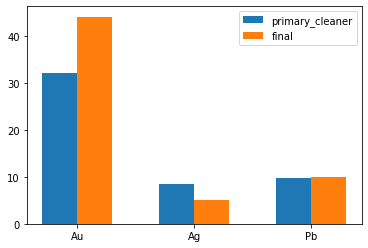

In [36]:
# названия металлов 
labels = ['Au', 'Ag', 'Pb']

# списки со средними значениями концентрации металлов 
primary_cleaner = [data_full['primary_cleaner.output.concentrate_au'].mean(), data_full['primary_cleaner.output.concentrate_ag'].mean(), data_full['primary_cleaner.output.concentrate_pb'].mean()]
final = [data_full['final.output.concentrate_au'].mean(), data_full['final.output.concentrate_ag'].mean(), data_full['final.output.concentrate_pb'].mean()]

display(primary_cleaner)
display(final)

# формирование столбчатой диаграммы 
x = np.arange(len(labels))
fig, ax = plt.subplots()
width = 0.3
ax.bar(x - width/2, primary_cleaner, width, label='primary_cleaner')
ax.bar(x + width/2, final, width, label='final')
ax.legend()
ax.set_xticks(x)
ax.set_xticklabels(labels)
fig.show()

#### Этап флотации
После этапа флотации концентрация металлов: 
* У золота (Au) увеличивается, почти в 2.5 раза.
* У серебра (Ag) возрастает на 37%.
* У свинца (Pb) увеличивается в 2 раза.

[8.266097326589103, 8.794927425814688, 3.5979597139398583]

[19.772000139486316, 11.994759359873429, 7.606272313195003]

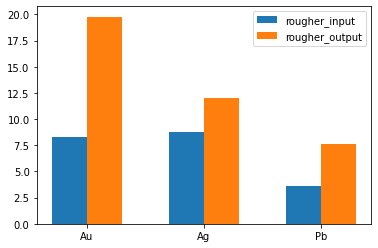

In [37]:
# названия металлов 
labels = ['Au', 'Ag', 'Pb']

# списки со средними значениями концентрации металлов 
rougher_input = [data_full['rougher.input.feed_au'].mean(), data_full['rougher.input.feed_ag'].mean(), data_full['rougher.input.feed_pb'].mean()]
rougher_output  = [data_full['rougher.output.concentrate_au'].mean(), data_full['rougher.output.concentrate_ag'].mean(), data_full['rougher.output.concentrate_pb'].mean()]

display(rougher_input)
display(rougher_output)

# формирование столбчатой диаграммы 
x = np.arange(len(labels))
fig, ax = plt.subplots()
width = 0.3
ax.bar(x - width/2, rougher_input, width, label='rougher_input')
ax.bar(x + width/2, rougher_output, width, label='rougher_output')
ax.legend()
ax.set_xticks(x)
ax.set_xticklabels(labels)
fig.show()

#### Золото (Au)

<AxesSubplot:>

5.627466192568694

5.1296519451435865

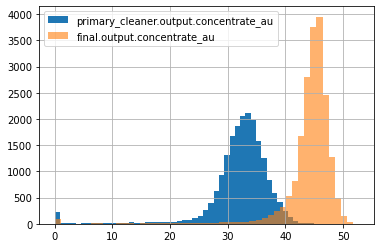

In [38]:
# гистограммы концентрации золота 
ax = data_full['primary_cleaner.output.concentrate_au'].hist(bins=50, legend=True)
display(data_full['final.output.concentrate_au'].hist(bins=50, ax=ax, legend=True, alpha=0.6))

# стандартные отклонения 
display(np.std(data_full['primary_cleaner.output.concentrate_au']))
display(np.std(data_full['final.output.concentrate_au']))

#### Серебро (Ag)

<AxesSubplot:>

2.054411672236725

1.3722787614643828

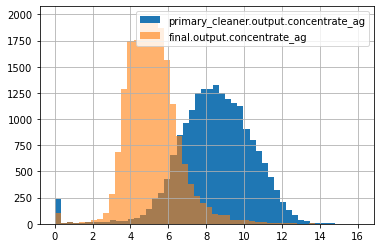

In [39]:
# гистограммы концентрации серебра 
ax = data_full['primary_cleaner.output.concentrate_ag'].hist(bins=50, legend=True)
display(data_full['final.output.concentrate_ag'].hist(bins=50, ax=ax, legend=True, alpha=0.6))

# стандартные отклонения 
display(np.std(data_full['primary_cleaner.output.concentrate_ag']))
display(np.std(data_full['final.output.concentrate_ag']))

#### Свинец (Pb)

<AxesSubplot:>

2.554752695450784

1.6691538271136712

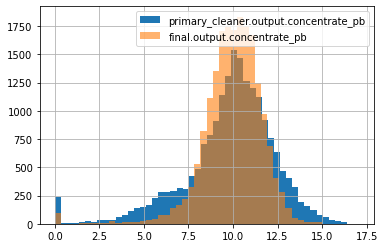

In [40]:
# гистограммы концентрации свинца 
ax = data_full['primary_cleaner.output.concentrate_pb'].hist(bins=50, legend=True)
display(data_full['final.output.concentrate_pb'].hist(bins=50, ax=ax, legend=True, alpha=0.6))

# стандартные отклонения 
display(np.std(data_full['primary_cleaner.output.concentrate_pb']))
display(np.std(data_full['final.output.concentrate_pb']))

### Размеры гранул сырья
Распределения размеров гранул сырья на разных этапах разработки схожи.

#### На этапе флотации

<AxesSubplot:>

60.1426461303941

55.86397810255099

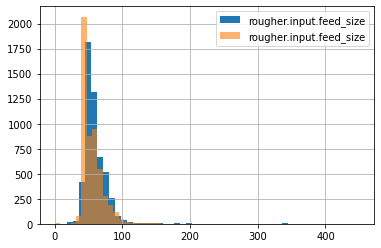

In [41]:
# гистограммы с размерами гранул сырья на тестовой и обучающей выборке на этапе флотации
ax = (data_train['rougher.input.feed_size'].sample(frac=len(data_test['rougher.input.feed_size']) / 
                                                        len(data_train['rougher.input.feed_size']),    
                                                   random_state=123).hist(bins=50, legend=True))
display(data_test['rougher.input.feed_size'].hist(bins=50, ax=ax, legend=True, alpha=0.6))

# среднее значение размеров гранул сырья на этапе флотации
display(data_train['rougher.input.feed_size'].mean())
display(data_test['rougher.input.feed_size'].mean())

#### На этапе первой очистки

<AxesSubplot:>

7.322309906901314

7.271545576079371

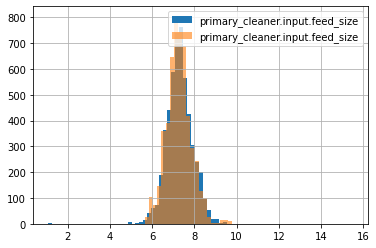

In [42]:
# гистограммы с размерами гранул сырья на тестовой и обучающей выборке на этапе первой очистки
ax = (data_train['primary_cleaner.input.feed_size'].sample(frac=len(data_test['primary_cleaner.input.feed_size']) / 
                                                                len(data_train['primary_cleaner.input.feed_size']),    
                                                           random_state=123).hist(bins=50, legend=True))
display(data_test['primary_cleaner.input.feed_size'].hist(bins=50, ax=ax, legend=True, alpha=0.6))

# среднее значение размеров гранул сырья на этапе первой очистки
display(data_train['primary_cleaner.input.feed_size'].mean())
display(data_test['primary_cleaner.input.feed_size'].mean())

### Суммарная концентрация всех веществ

Суммарная концентрация всех веществ от сырья до финального концентрата увеличивается на 20%, после каждого этапа концентрация возрастает.

In [43]:
# функция для расчета суммарной концентрации всех веществ
def sum_concentrate(data, stage):
    if stage == 'final': # финальный концентрат
        au = data['final.output.concentrate_au']
        ag = data['final.output.concentrate_ag']    
        pb = data['final.output.concentrate_pb']    
        sol = data['final.output.concentrate_sol']    
        return au + ag + pb + sol
    
    elif stage == 'rougher_input': # сырье
        au = data['rougher.input.feed_au']
        ag = data['rougher.input.feed_ag']    
        pb = data['rougher.input.feed_pb']    
        sol = data['rougher.input.feed_sol']    
        return au + ag + pb + sol
    
    elif stage == 'rougher_output': # черновой концентрат
        au = data['rougher.output.concentrate_au']
        ag = data['rougher.output.concentrate_ag']    
        pb = data['rougher.output.concentrate_pb']    
        sol = data['rougher.output.concentrate_sol']    
        return au + ag + pb + sol

#### Изменение суммарной концентрации

rougher_input     57.339866
rougher_output    68.178656
final             68.698294
dtype: float64

<AxesSubplot:>

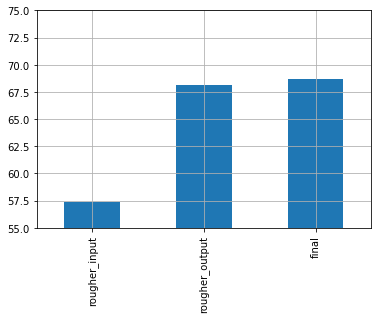

In [44]:
# расчет суммарной концентрации веществ на разных этапах разработки
sum_rougher_input_concentrate = data_full.apply(sum_concentrate, stage='rougher_input', axis=1)
sum_rougher_output_concentrate = data_full.apply(sum_concentrate, stage='rougher_output', axis=1)
sum_final_concentrate = data_full.apply(sum_concentrate, stage='final', axis=1)

# объект Series с суммарной концентрацией веществ
x = (pd.Series([sum_rougher_input_concentrate.mean(), sum_rougher_output_concentrate.mean(), sum_final_concentrate.mean()])
       .set_axis(['rougher_input', 'rougher_output', 'final']))

display(x)

# столбчатая диаграмма 
display(x.plot(kind='bar', ylim=(55, 75), grid=True))

#### Распределения суммарных концентраций
Суммарная концентрация увеличивается к этапу чернового концентрата, на этапе финального же становится менее разбросанная вокруг среднего значения. 

<AxesSubplot:>

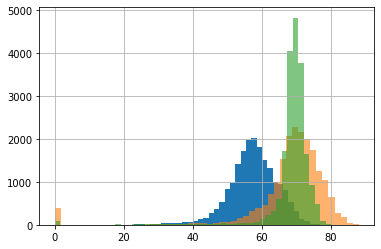

In [45]:
# суммарная концентрация сырья
sum_rougher_input_concentrate.hist(bins=50)

# суммарная концентрация чернового концентрата
sum_rougher_output_concentrate.hist(bins=50, alpha=0.6)

# суммарная концентрация финального концентрата
sum_final_concentrate.hist(bins=50, alpha=0.6)

## Модель

### Итоговая sMAPE

In [46]:
# функция для расчета sMAPE
def smape_func(target, predictions, **kwargs): 
    target = np.array(target)
    predictions = np.array(predictions)
    return (np.abs(target - predictions) / ((np.abs(target) + np.abs(predictions)) / 2)).mean() * 100

# функция для расчета итоговой sMAPE
def final_smape_func(smape_rougher, smape_final):
    return smape_rougher * 0.25 + smape_final * 0.75

# формирование метрики
smap_error = make_scorer(smape_func, greater_is_better=False)

### Обучение моделей
Наименьшую итоговую ошибку sMAPE показывает модель 'случайный лес' с подобранными гиперпараметрами: 2.3%

#### Признаки и целевые признаки
Небольшое количество значений целевых признаков равно нулю, их необходимо удалить из выборок, чтобы расчет ключевых метрик работал исправно.

In [47]:
# удаление объектов с целевыми признаками равными нулю
data_train = data_train.drop(data_train[data_train['final.output.recovery'] == 0].index, axis=0)
data_train = data_train.drop(data_train[data_train['rougher.output.recovery'] == 0].index, axis=0)

# признаки и целевые признаки обучающей выборки
features_train = data_train[data_test.columns].drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis=1)
target_train_rougher = data_train['rougher.output.recovery']
target_train_final = data_train['final.output.recovery']

# признаки и целевые признаки тестовой выборки
features_test = data_test.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis=1)
target_test_rougher = data_test['rougher.output.recovery']
target_test_final = data_test['final.output.recovery']

#### Дерево решений
Итоговая sMAPE:
* С подобранными гиперпараметрами : 4.9%
* Высчитанная с помощью кросс-валидации: 12%

##### Подбор гиперпараметров

In [48]:
# вариации гиперпараметров
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]

# сетка гиперпараметров
parameters_grid = {'min_samples_split':min_samples_split,
                   'min_samples_leaf':min_samples_leaf,
                   'max_depth':max_depth}

# модель 'дерево решений'
model_tree = GridSearchCV(DecisionTreeRegressor(random_state=1), parameters_grid, scoring=smap_error, cv=3)

# обучение на признаках на этапе rougher и последующее нахождение ошибки 
model_tree_fited_rougher = model_tree.fit(features_train, target_train_rougher)
smape_rougher_cv = model_tree.best_score_
smape_rougher = smape_func(target_train_rougher, model_tree.predict(features_train))

# обучение на признаках на этапе final и последующее нахождение ошибки 
model_tree_fited_final = model_tree.fit(features_train, target_train_final)
smape_final_cv = model_tree.best_score_
smape_final = smape_func(target_train_final, model_tree.predict(features_train))

# итоговая sMAPE
display(final_smape_func(smape_rougher, smape_final))
# итоговая sMAPE по результатам кросс-валидации
display(final_smape_func(smape_rougher_cv, smape_final_cv))

4.981739742426488

-12.062217079721233

#### Линейная регрессия
Итоговая sMAPE:
* С подобранными гиперпараметрами : 7.2%
* Высчитанная с помощью кросс-валидации: 12.5%

##### Подбор гиперпараметров

In [49]:
# вариации гиперпараметров
fit_intercept = [True, False]
normalize = [True, False]

# сетка гиперпараметров
parameters_grid = {'fit_intercept':fit_intercept,
                   'normalize':normalize}

# модель 'линейная регрессия'
model_log_reg = GridSearchCV(LinearRegression(), parameters_grid, scoring=smap_error, cv=3)

# обучение на признаках на этапе rougher и последующее нахождение ошибки 
model_log_fited_rougher = model_log_reg.fit(features_train, target_train_rougher)
smape_rougher_cv = model_log_reg.best_score_
smape_rougher = smape_func(target_train_rougher, model_log_reg.predict(features_train))

# обучение на признаках на этапе final и последующее нахождение ошибки 
model_log_fited_final = model_log_reg.fit(features_train, target_train_final)
smape_final_cv = model_log_reg.best_score_
smape_final = smape_func(target_train_final, model_log_reg.predict(features_train))

# итоговая sMAPE
display(final_smape_func(smape_rougher, smape_final))
# итоговая sMAPE по результатам кросс-валидации
display(final_smape_func(smape_rougher_cv, smape_final_cv))

7.243122919281699

-12.550082664446645

#### Случайный лес
Итоговая sMAPE:
* С подобранными гиперпараметрами : 2.1%
* Высчитанная с помощью кросс-валидации: 5.4%

##### Подбор гиперпараметров
Пришлось уменьшить размеры обучающих выборок, так как подбор длился очень долго.

In [64]:
# вариации гиперпараметров
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
n_estimators = [int(x) for x in np.linspace(10, 30, num = 3)]

# сетка гиперпараметров
parameters_grid = {'max_depth':max_depth,
                   'n_estimators':n_estimators}

# модель 'случайный лес'
model_forest = GridSearchCV(RandomForestRegressor(random_state=1), parameters_grid, scoring=smap_error, cv=3)

# обучение на признаках на этапе rougher и последующее нахождение ошибки 
model_forest_fited_rougher = model_forest.fit(features_train.sample(frac=0.7, random_state=1), 
                                              target_train_rougher.sample(frac=0.7, random_state=1))
smape_rougher_cv = model_forest.best_score_
smape_rougher = smape_func(target_train_rougher.sample(frac=0.7, random_state=1), 
                           model_forest.predict(features_train.sample(frac=0.7, random_state=1)))

# обучение на признаках на этапе final и последующее нахождение ошибки 
model_forest_fited_final = model_forest.fit(features_train.sample(frac=0.7, random_state=1), 
                                            target_train_final.sample(frac=0.7, random_state=1))
smape_final_cv = model_forest.best_score_
smape_final = smape_func(target_train_final.sample(frac=0.7, random_state=1), 
                         model_forest.predict(features_train.sample(frac=0.7, random_state=1)))

# итоговая sMAPE
display(final_smape_func(smape_rougher, smape_final))
# итоговая sMAPE по результатам кросс-валидации
display(final_smape_func(smape_rougher_cv, smape_final_cv))

2.1360398525958875

-5.461622210403438

### Проверка модели на тестовой выборке
На тестовой выборке выбранная модель 'случайный лес' с подобранными гиперпараметрами показывает итоговое симметричное среднее абсолютное отклонение равное 13.8%

In [65]:
# предсказывание эффективности на этапе флотации
pred_test_rougher = model_forest_fited_rougher.predict(features_test)

# предсказывание эффективности на финальном этапе
pred_test_final = model_forest_fited_final.predict(features_test)

In [66]:
# расчет итогового sMAPE
smape_rougher = smape_func(target_test_rougher, pred_test_rougher)
smape_final = smape_func(target_test_final, pred_test_final)
display(final_smape_func(smape_rougher, smape_final))

13.854608653906364

### Сравнение модели с константной
Итоговая sMAPE: 9.4%

In [67]:
# константная модель
dummy_model = DummyRegressor(strategy='mean')

# обучение на признаках на этапе rougher и последующее нахождение ошибки 
dummy_model.fit(features_train, target_train_rougher)
smape_rougher = smape_func(target_test_rougher, dummy_model.predict(features_test))

# обучение на признаках на этапе final и последующее нахождение ошибки 
dummy_model.fit(features_train, target_train_final)
smape_final = smape_func(target_test_final, dummy_model.predict(features_test))

# итоговая sMAPE
display(final_smape_func(smape_rougher, smape_final))

9.40025945588301

## Вывод

* С помощью написанной функции проверили верно ли рассчитана эффективность разработки.
* Изменили тип данных признака 'date' на datetime64; <br>
обработали пропуски в обучающих и полных данных с помощью метода k-ближайших соседей, в тестовой выборке удалили объекты с пропусками для корректного обучения предсказывания моделей; <br>
проверили данные на наличие явных дубликатов.
* Проанализировали изменение концентрации металлов после этапов очистки:
 * У золота (Au) после второго этапа очистки возрастает, примерно на 30%.
 * У серебра (Ag) после второго этапа очистки уменьшается почти на 40%.    
 * У свинца (Pb) увеличивается на 1.5%, изменение по сравнению с другими металлами очень маленькое.
* Проанализировали изменение концентрации металлов после этапа флотации:
 * У золота (Au) увеличивается, почти в 2.5 раза.
 * У серебра (Ag) возрастает на 37%.
 * У свинца (Pb) увеличивается в 2 раза.
* Выяснили, что размеры гранул сырья на разных этапах разработки схожи.
* Узнали, что суммарная концентрация всех веществ от сырья до финального концентрата увеличивается на 20%, после каждого этапа концентрация возрастает; <br>
а так же, суммарная концентрация увеличивается к этапу чернового концентрата, на этапе финального же становится менее разбросанная вокруг среднего значения. 
* Написали функции для расчета sMAPE и итоговой sMAPE.
* Выделили признаки и целевые признаки обучающих и тестовых выборок.
* Рассмотрели три модели 'дерево решений', 'линейная регрессия' и 'случайный лес':
 * Наименьшая итоговая sMAPE найденная с кросс-валидацией:
   * 'случайный лес': 5.4%
 * Наименьшая итоговая sMAPE найденная с кросс-валидацией и подобранными гиперпараметрами:
   * 'случайный лес': 2.1%
* Итоговая sMAPE на тестовых данных с выбранной моделью 'случайный лес': 13.8%

  
  